<a href="https://colab.research.google.com/github/aandrijana/Image-Colorization-Project/blob/main/model_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

Pix2Pix (Isola et al., 2017) is a type of conditional Generative Adversarial Network (cGAN) designed for supervised image-to-image translation tasks — such as grayscale-to-color conversion — where paired input and target images are available during training.

In the Pix2Pix framework:

* The generator is typically a U-Net architecture, which captures both low-level and high-level features through skip connections, enabling accurate reconstruction of spatial details.

* The discriminator is a PatchGAN, which classifies whether local image patches (e.g., 70×70 regions) are real or fake. This helps enforce local realism and texture consistency across the output image.

* Conditional input: As a cGAN, Pix2Pix conditions both the generator and discriminator on the input image. In our case, the grayscale (L-channel) image is used as the conditioning input. This guides the model to learn the mapping from grayscale intensities to realistic color distributions.

Pix2Pix is trained using a combination of:

* Adversarial loss to encourage the generator to produce realistic colorizations that fool the discriminator.

* L1 loss (between the generated and target color images) to preserve structural and content fidelity, ensuring the output remains faithful to the input.

This combination allows Pix2Pix to generate sharp, contextually accurate colorizations that align closely with the input grayscale structure.



## Libraries to include:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from IPython.display import clear_output
#!pip install -q scipy tqdm
from scipy.linalg import sqrtm
from tqdm import tqdm

In [ ]:
DRIVE_BASE_PATH = "/content/drive/MyDrive/ImageColorization"
MODELS_DIR = os.path.join(DRIVE_BASE_PATH, "saved_models")
PROGRESS_DIR = os.path.join(DRIVE_BASE_PATH, "training_progress")
os.makedirs(MODELS_DIR, exist_ok=True)

# The Checkpoint object will track the models and their optimizers.
# Saving optimizer state is crucial for resuming training properly.
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# The CheckpointManager handles saving checkpoints to the specified directory.
# `max_to_keep` determines how many recent checkpoints are stored.
ckpt_manager = tf.train.CheckpointManager(checkpoint, MODELS_DIR, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print(f"✅ Restored from {ckpt_manager.latest_checkpoint}")
else:
    print("✅ Initializing from scratch.")


To manage training effectively within the constraints of available GPU resources, we implemented a checkpointing system that saves model states directly to Google Drive. This approach ensures training progress is preserved across sessions and allows for seamless recovery or continuation, especially in environments with limited runtime duration

## U-net

The U-Net architecture serves as our Generator, transforming single-channel grayscale (L) inputs into two-channel chrominance (AB) outputs using an encoder-decoder structure with skip connections. The encoder's downsampling strategy involves repeated Conv2D layers with strides=2, effectively halving spatial dimensions at each step while progressively increasing feature filters to capture multi-scale information.

In [ ]:
# Let's define the output channels for the generator.
# We want to predict the 'a' and 'b' channels.
OUTPUT_CHANNELS = 2

def downsample(filters, size, apply_batchnorm=True):
    """
    Creates a downsampling block used in the encoder.
    Consists of Conv2D -> BatchNormalization (optional) -> LeakyReLU.
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    """
    Creates an upsampling block used in the decoder.
    Consists of Conv2DTranspose -> BatchNormalization -> Dropout (optional) -> ReLU.
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def build_generator(input_shape=(128, 128, 1)):
    """
    Builds the U-Net Generator model.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling Path)
    # The output of each block will be used for skip connections
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 64, 64, 64)
        downsample(128, 4),                      # (bs, 32, 32, 128)
        downsample(256, 4),                      # (bs, 16, 16, 256)
        downsample(512, 4),                      # (bs, 8, 8, 512)
        downsample(512, 4),                      # (bs, 4, 4, 512)
        downsample(512, 4),                      # (bs, 2, 2, 512)
        downsample(512, 4),                      # (bs, 1, 1, 512)
    ]

    # Decoder (Upsampling Path)
    up_stack = [
        upsample(512, 4, apply_dropout=True),    # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),    # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),    # (bs, 8, 8, 1024)
        upsample(256, 4),                        # (bs, 16, 16, 512)
        upsample(128, 4),                        # (bs, 32, 32, 256)
        upsample(64, 4),                         # (bs, 64, 64, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 128, 128, 2)

    x = inputs

    # Loop through the encoder and save skip connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1]) # Reverse the list and drop the last one (bottleneck)

    # Loop through the decoder, establish skip connections, and upsample
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    # Final layer to bring it back to the target image size
    x = last(x)

    return Model(inputs=inputs, outputs=x)

generator = build_generator()
generator.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64,    │      1,024 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 16,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 8, 512) │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 4, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 2, 2, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 1, 1, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 2, 2, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 16, 16,    │  4,195,328 │ concatenate_2[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 32, 32,    │  1,049,088 │ concatenate_3[0]

 Total params: 41,834,754 (159.59 MB)

 Trainable params: 41,825,922 (159.55 MB)

 Non-trainable params: 8,832 (34.50 KB)

## PatchGAN Discriminator

Our Discriminator is built using the PatchGAN architecture, designed to differentiate between real and generated color images. It takes two inputs: the original grayscale L channel and either the real AB channels or the Generator's predicted AB channels. <br> <br>
The L and AB channels are concatenated to form a 3-channel input, which then passes through a series of downsampling convolutional layers. Unlike a typical discriminator that outputs a single "real/fake" probability for the entire image, PatchGAN outputs a **grid of classifications** (a "patch" output). Each value in this grid represents the likelihood that a corresponding patch in the input image is "real," compelling the Generator to produce high-quality, realistic colorization across the entire image.

In [ ]:
def build_discriminator(input_shape_l=(128, 128, 1), input_shape_ab=(128, 128, 2)):
    """
    Builds the PatchGAN Discriminator model.
    This is a conditional discriminator, taking both the input L-channel and the target/generated ab-channels.
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input L-channel image (the condition)
    input_l = layers.Input(shape=input_shape_l, name='input_l_channel')

    # Target image (either real or fake ab-channels)
    input_ab = layers.Input(shape=input_shape_ab, name='input_ab_channels')

    # Concatenate the condition (L channel) and the target (ab channels)
    # This forms the input to the discriminator: (bs, 128, 128, 1+2=3)
    x = layers.Concatenate()([input_l, input_ab])

    # Downsampling layers

    # Layer 1: C64 - No BatchNormalization in the first layer as per the paper
    down1 = downsample(64, 4, apply_batchnorm=False)(x) # (bs, 64, 64, 64)
    # Layer 2: C128
    down2 = downsample(128, 4)(down1) # (bs, 32, 32, 128)
    # Layer 3: C256
    down3 = downsample(256, 4)(down2) # (bs, 16, 16, 256)

    # Add a zero padding layer
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 18, 18, 256)

    # Layer 4: C512 with stride 1
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 15, 15, 512)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    # Add another zero padding layer
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 17, 512)

    # Final Layer: Produces the 1-channel patch output
    # This is the 2D grid of patch classifications
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 14, 14, 1)

    return Model(inputs=[input_l, input_ab], outputs=last)

discriminator = build_discriminator()
discriminator.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_l_channel     │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ab_channels   │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 128,  │          0 │ input_l_channel[… │
│ (Concatenate)       │ 3)                │            │ input_ab_channel… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64, 64,    │      3,072 │ concatenate_6[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 32, 32,    │    131,584 │ sequential_13[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 16, 16,    │    525,312 │ sequential_14[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 18, 18,    │          0 │ sequential_15[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 15, 15,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      2,048 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 17, 17,    │          0 │ leaky_re_lu_10[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 14, 14, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Generator loss

Generator Loss Function in Pix2Pix

The generator's loss function combines two complementary objectives to produce both realistic and structurally accurate colorizations:

Adversarial Loss (GAN Loss):
This loss encourages the generator to produce outputs that are indistinguishable from real images by the discriminator. It is computed using binary cross-entropy, comparing the discriminator’s prediction for generated images against a target of all ones (indicating "real").

L1 Loss (Mean Absolute Error):
This pixel-wise loss penalizes differences between the generated image and the ground truth target. It promotes structural similarity and discourages artifacts or mode collapse, ensuring the generated colors align with the input image's content.

$$
\mathcal{L}_{\text{generator}} = \mathcal{L}_{\text{GAN}} + \lambda \cdot \mathcal{L}_{\text{L1}}
$$


where λ (LAMBDA) is a weighting factor.

In [ ]:
# The weight for the L1 loss component. As per the pix2pix paper, 100 is a good value.
LAMBDA = 100

# We will use BinaryCrossentropy for the adversarial loss.
# `from_logits=True` is important because our discriminator's output is a logit (it doesn't have a final sigmoid).
# This is more numerically stable than applying a sigmoid and then calculating the loss.
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    """
    Calculates the generator's loss.

    Args:
      disc_generated_output: The output of the discriminator when given the generator's output.
                             This is the grid of patch classifications (e.g., shape [bs, 14, 14, 1]).
      gen_output: The generator's output image (the predicted ab channels).
                  Shape is [bs, 128, 128, 2].
      target: The ground truth image (the real ab channels).
              Shape is [bs, 128, 128, 2].

    Returns:
      The total generator loss, a scalar value.
    """
    # 1. Adversarial Loss
    # The generator wants the discriminator to classify the generated images as "real".
    # Therefore, we compare the discriminator's output on fake images to a tensor of all 1s.
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # 2. L1 Loss (Mean Absolute Error)
    # This measures the pixel-wise absolute difference between the generated image and the ground truth target.
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # 3. Total Generator Loss
    # The final loss is the weighted sum of the adversarial loss and the L1 loss.
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

Effect of Different λ Values: <br>
* Lower λ values (e.g., 10–50):
The generator prioritizes fooling the discriminator more than matching the ground truth. This may lead to sharper but less accurate outputs, potentially introducing unrealistic colors or artifacts.

* Higher λ values (e.g., 100–200+):
The generator focuses more heavily on minimizing the L1 error, which improves faithfulness to the ground truth but can lead to blurrier or overly conservative outputs if adversarial loss is under-emphasized.

In our final model, we retained the λ value of 100, consistent with the original [Pix2Pix paper](https://arxiv.org/pdf/1611.07004v3). While we experimented with lower values in earlier versions, these adjustments did not yield significant improvements in output quality or training stability. As such, the default value of 100 provided a balanced trade-off between visual realism and content fidelity in our grayscale-to-color translation task.

## Discriminator loss

The Discriminator's loss function trains it to accurately distinguish between real and fake color images. It's composed of two parts:
* **Real Image Loss**: This measures how well the discriminator identifies real images as real. It's calculated by comparing the discriminator's output for real images against a tensor of all ones.
* **Fake Image Loss**: This measures how well the discriminator identifies generated (fake) images as fake. It's calculated by comparing the discriminator's output for fake images against a tensor of all zeros.

Both components use BinaryCrossentropy with from_logits=True for numerical stability. The total discriminator loss is simply the sum of these two losses, driving the discriminator to become an effective critic.

In [ ]:
# We use the same loss object as for the generator's adversarial loss.
# `from_logits=True` is crucial because our discriminator does not have a final sigmoid activation.
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    Calculates the discriminator's loss.

    The discriminator's loss is the sum of its losses on real and fake images.

    Args:
      disc_real_output: The discriminator's output when given real images.
                        Shape is [bs, 14, 14, 1].
      disc_generated_output: The discriminator's output when given fake (generated) images.
                             Shape is [bs, 14, 14, 1].

    Returns:
      The total discriminator loss, a scalar value.
    """
    # 1. Loss on real images
    # We compare the discriminator's predictions on real images to a tensor of all 1s.
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    # 2. Loss on fake images
    # We compare the discriminator's predictions on fake images to a tensor of all 0s.
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    # 3. Total Discriminator Loss
    # The total loss is the sum of the two losses.
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Training

### Train step

**Adam Optimizer** is used for both networks, with a learning rate of 2×10⁻⁴ and β₁ = 0.5, as recommended in the original Pix2Pix paper.

These hyperparameters are chosen to stabilize GAN training by reducing the momentum of past gradients (via beta_1) and promoting smoother convergence.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_l, target_ab):
    """
    Executes one training step for both the generator and discriminator.

    This function is decorated with @tf.function to compile it into a
    high-performance TensorFlow graph.
    """
    # Use two separate GradientTapes to track gradients for each model.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # --- Generator Forward Pass ---
        # The generator creates fake 'ab' channels from the input 'L' channel.
        gen_output = generator(input_l, training=True)

        # --- Discriminator Forward Pass ---
        # The discriminator evaluates two pairs:
        # 1. Input 'L' channel with the REAL 'ab' channels.
        # 2. Input 'L' channel with the FAKE (generated) 'ab' channels.
        disc_real_output = discriminator([input_l, target_ab], training=True)
        disc_generated_output = discriminator([input_l, gen_output], training=True)

        # --- Calculate Losses ---
        # Calculate the generator and discriminator losses using our predefined functions.
        gen_total_loss = generator_loss(disc_generated_output, gen_output, target_ab)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # --- Calculate and Apply Gradients ---
    # Calculate gradients for each model with respect to its loss.
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the calculated gradients to update the model weights.
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Return the losses for monitoring
    return gen_total_loss, disc_loss

The train_step function, optimized with @tf.function, executes a single, high-performance training iteration for both the Generator and Discriminator.

Inside, the Generator first produces fake AB channels from the L input. Then, the Discriminator evaluates both real (L + actual AB) and fake (L + generated AB) image pairs. Their respective losses are calculated. Finally, gradients are computed and applied via separate tf.GradientTape instances and optimizers, synchronously updating both models in the adversarial process.

### Image Generation and Visualization at Each Epoch

The generate_and_save_images function serves as a key utility for visualizing the generator's performance during training. It executes at the end of each epoch to create side-by-side comparisons of the model's predictions against the ground truth, using a representative sample from the validation set.

In [ ]:
#From our Data Exploration and Data Preprocessing
L_IN_MIN, L_IN_MAX = 0.0, 255.0
A_IN_MIN, A_IN_MAX = 42.0, 226.0
B_IN_MIN, B_IN_MAX = 20.0, 223.0

def generate_and_save_images(model, epoch, test_input_l, target_ab):
    prediction_ab = model(test_input_l, training=False)

    # We need to denormalize everything to be visualized
    # Isolate the first image from the batch
    l_norm = test_input_l[0]
    ab_targ_norm = target_ab[0]
    ab_pred_norm = prediction_ab[0]

    # Revert L from [-1, 1] back to its original [0, 255] range
    l_reverted = (l_norm + 1) / 2.0 * (L_IN_MAX - L_IN_MIN) + L_IN_MIN
    # Then scale from [0, 255] to the [0, 100] range that cv2.cvtColor expects
    l_for_cv2 = l_reverted * (100.0 / 255.0)

    # Denormalize AB channels (both target and prediction)
    def denormalize_ab(ab_norm):
        a_norm = ab_norm[..., 0:1]
        b_norm = ab_norm[..., 1:2]
        # Revert from [-1, 1] back to the original custom ranges
        a_reverted = (a_norm + 1) / 2.0 * (A_IN_MAX - A_IN_MIN) + A_IN_MIN
        b_reverted = (b_norm + 1) / 2.0 * (B_IN_MAX - B_IN_MIN) + B_IN_MIN
        # Now shift from the custom uint8 range to the [-128, 127] range cv2 expects
        ab_for_cv2 = tf.concat([a_reverted - 128.0, b_reverted - 128.0], axis=-1)
        return ab_for_cv2

    ab_targ_for_cv2 = denormalize_ab(ab_targ_norm)
    ab_pred_for_cv2 = denormalize_ab(ab_pred_norm)

    # --- Reconstruct and Convert ---
    lab_real = tf.concat([l_for_cv2, ab_targ_for_cv2], axis=-1).numpy()
    lab_pred = tf.concat([l_for_cv2, ab_pred_for_cv2], axis=-1).numpy()

    rgb_real = cv2.cvtColor(lab_real.astype('float32'), cv2.COLOR_LAB2RGB)
    rgb_pred = cv2.cvtColor(lab_pred.astype('float32'), cv2.COLOR_LAB2RGB)

    rgb_real = np.clip(rgb_real, 0, 1)
    rgb_pred = np.clip(rgb_pred, 0, 1)

    gray_input = tf.squeeze(l_for_cv2).numpy() # Display the correctly scaled L channel

    # --- Plotting ---
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Input L-Channel')
    plt.imshow(gray_input, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Predicted Color Image')
    plt.imshow(rgb_pred)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Ground Truth Color')
    plt.imshow(rgb_real)
    plt.axis('off')

    plt.savefig(os.path.join(PROGRESS_DIR, f'image_at_epoch_{epoch:04d}.png'))
    plt.show()

It uniquely denormalizes the L and AB channels—reversing the normalization applied during preprocessing—scaling the channels back to the ranges expected by OpenCV’s cv2.cvtColor function. Using cv2.cvtColor, the reconstructed LAB images are converted to RGB format for accurate color visualization.

### Fit function and metrics we used

This section implements the main training loop (fit function) for the Pix2Pix model, along with key quantitative metrics to monitor performance.

In [ ]:
gen_loss_history = []
disc_loss_history = []
psnr_history = []
ssim_history = []

In [ ]:
# Create a fixed validation batch for consistent evaluation
fixed_val_l, fixed_val_ab = next(iter(val_dataset))

We create a fixed validation batch at the start to consistently evaluate the model’s progress at every epoch. This ensures comparable visualizations and metrics across epochs.

In [ ]:
def calculate_metrics(y_true, y_pred):
    """
    Calculates average PSNR and SSIM for a batch of images.
    Assumes input tensors are in the normalized [-1, 1] range.
    """
    # Denormalize from [-1, 1] to the required [0, 1] range
    y_true = (y_true + 1) / 2.0
    y_pred = (y_pred + 1) / 2.0

    psnr = tf.image.psnr(y_true, y_pred, max_val=1.0)
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)

    return tf.reduce_mean(psnr), tf.reduce_mean(ssim)

The calculate_metrics function computes average PSNR (Peak Signal-to-Noise Ratio) and SSIM (Structural Similarity Index Measure) on batches of generated vs. ground truth images. Inputs are assumed normalized in [-1, 1] and are rescaled to [0, 1] for metric calculation.

* PSNR (Peak Signal-to-Noise Ratio):
PSNR quantifies the difference between a reconstructed (generated) image and the original image by measuring the pixel-wise error. It is expressed in decibels (dB), where a higher PSNR value indicates that the reconstructed image is closer to the original, meaning less distortion or noise. PSNR is useful for assessing overall fidelity but does not always correlate perfectly with human visual perception.

* SSIM (Structural Similarity Index Measure):
SSIM measures the perceptual similarity between two images by comparing three components: luminance (brightness), contrast, and structural information (patterns). Unlike PSNR, SSIM focuses on perceived changes in image quality and is better aligned with human vision. SSIM values range from -1 to 1, with values closer to 1 indicating high similarity and better perceptual quality.

In [ ]:
def fit(train_ds, val_ds, epochs):
    # The main training loop
    for epoch in range(epochs):
        start = time.time()
        clear_output(wait=True)
        print(f"Epoch {epoch + 1}/{epochs}")

        # Generate progress images using our fixed validation batch
        generate_and_save_images(generator, epoch, fixed_val_l, fixed_val_ab)

        # --- Training over all batches ---
        epoch_gen_loss = []
        epoch_disc_loss = []
        for n, (input_l, target_ab) in enumerate(train_ds):
            if (n + 1) % 100 == 0: # Adjusted print frequency
                print(f"  - Batch {n + 1}/{len(train_ds)}")
            gen_loss, disc_loss = train_step(input_l, target_ab)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

        # 1. Calculate and store average training losses
        avg_gen_loss = np.mean(epoch_gen_loss)
        avg_disc_loss = np.mean(epoch_disc_loss)
        gen_loss_history.append(avg_gen_loss)
        disc_loss_history.append(avg_disc_loss)

        # 2. Calculate and store validation metrics >>>
        val_pred_ab = generator(fixed_val_l, training=False)
        psnr, ssim = calculate_metrics(fixed_val_ab, val_pred_ab)
        psnr_history.append(psnr.numpy())
        ssim_history.append(ssim.numpy())

        # 3. Save checkpoint
        if (epoch + 1) % 5 == 0:
            save_path = ckpt_manager.save()
            print(f"✅ Saved checkpoint for epoch {epoch + 1} at {save_path}")

        # 4. Print epoch summary (now including metrics)
        print(f'Time taken for epoch {epoch + 1} is {time.time()-start:.2f} sec')
        print(f'  Avg Gen Loss: {avg_gen_loss:.4f} | Avg Disc Loss: {avg_disc_loss:.4f} | '
              f'Val PSNR: {psnr:.2f} | Val SSIM: {ssim:.4f}\n')

    # Final checkpoint save at the end of training
    final_save_path = ckpt_manager.save()
    print(f"✅ Training finished. Final checkpoint saved at {final_save_path}")

The fit function runs the full training process over a set number of epochs. It trains the model on batches from the training dataset, tracks generator and discriminator losses, and evaluates PSNR and SSIM on a fixed validation batch each epoch. Progress images are generated for visual monitoring, and model checkpoints are saved periodically to preserve training state. This setup ensures robust tracking of both quantitative metrics and qualitative results throughout training.

Epoch 100/100


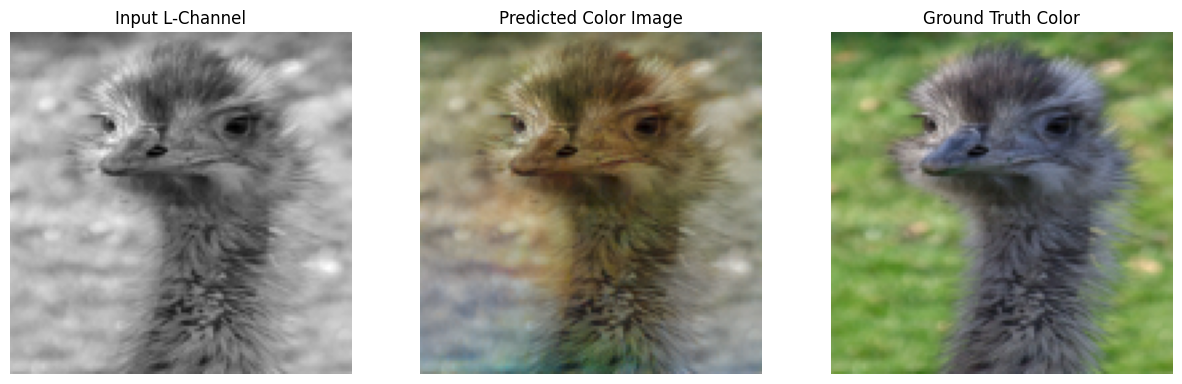

  - Batch 100/135
✅ Saved checkpoint for epoch 100 at /content/drive/MyDrive/ImageColorization/saved_models/ckpt-20
Time taken for epoch 100 is 47.34 sec
  Avg Gen Loss: 8.1405 | Avg Disc Loss: 0.7745 | Val PSNR: 20.69 | Val SSIM: 0.6419

✅ Training finished. Final checkpoint saved at /content/drive/MyDrive/ImageColorization/saved_models/ckpt-21


In [ ]:
EPOCHS = 100 #First we start with 100 epochs
print("--- Starting Full Training ---")
fit(train_dataset, val_dataset, epochs=EPOCHS)

After 100 epochs, the model demonstrates a reasonable balance between generator and discriminator losses, with an average generator loss of 8.14 and discriminator loss of 0.77. The validation metrics show a PSNR of 20.69 and an SSIM of 0.64, indicating the model produces colorized images that retain significant structural similarity and perceptual quality relative to the ground truth.

The qualitative results reflect this performance: the predicted color image captures the general color tones and shapes of the original but still exhibits some blurriness and color bleeding compared to the ground truth. Overall, the model shows solid progress but could benefit from further fine-tuning or additional training for sharper and more precise colorization.

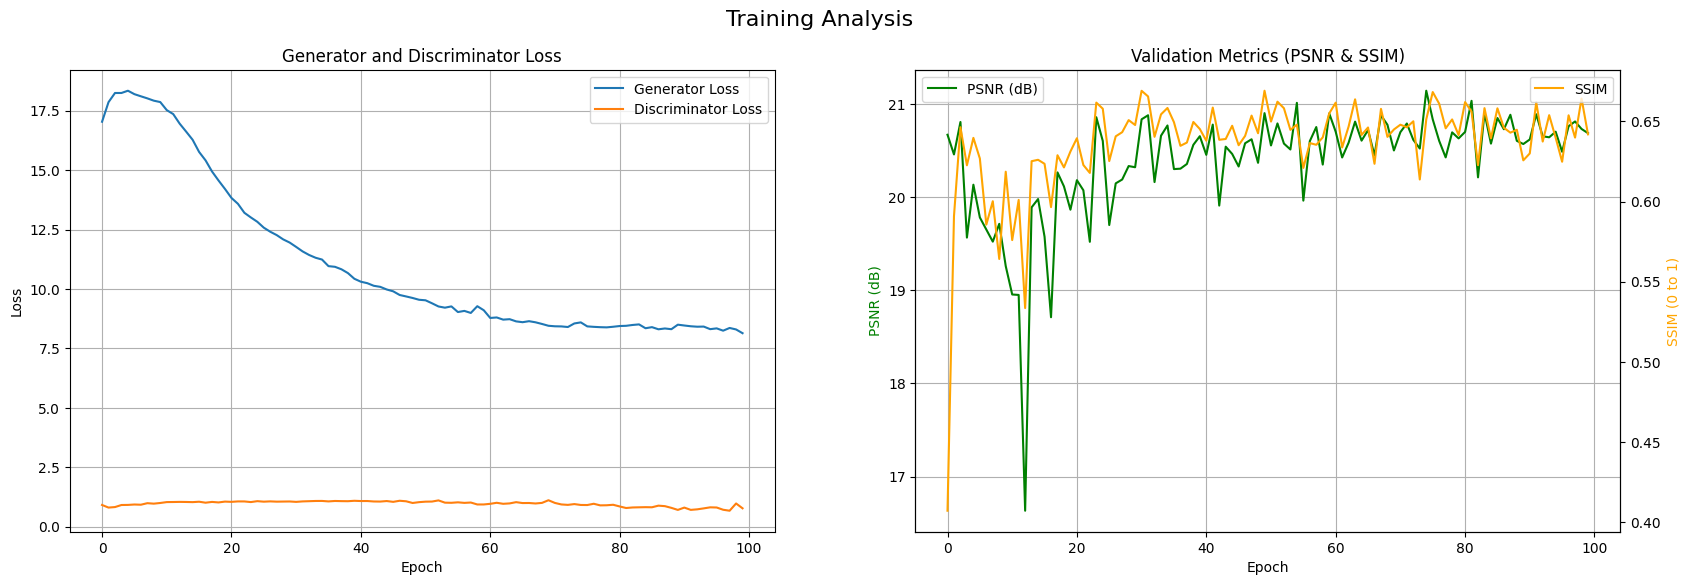

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot Losses on the first subplot
ax1.set_title("Generator and Discriminator Loss")
ax1.plot(gen_loss_history, label="Generator Loss")
ax1.plot(disc_loss_history, label="Discriminator Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Plot Metrics on the second subplot
ax2.set_title("Validation Metrics (PSNR & SSIM)")
ax2.plot(psnr_history, label="PSNR (dB)", color='g')
# We need a second y-axis for SSIM since its scale is different
ax2_ssim = ax2.twinx()
ax2_ssim.plot(ssim_history, label="SSIM", color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("PSNR (dB)", color='g')
ax2_ssim.set_ylabel("SSIM (0 to 1)", color='orange')
ax2.legend(loc='upper left')
ax2_ssim.legend(loc='upper right')
ax2.grid(True)

plt.suptitle("Training Analysis", fontsize=16)
plt.show()

* Generator loss steadily decreases from a high initial value (~18) to around 8, indicating the generator is improving its output quality over time.

* Discriminator loss stays relatively low and stable (around 0.7 to 1), suggesting the discriminator is effectively distinguishing real from generated images without overpowering the generator.
* Validation metrics (PSNR and SSIM) gradually improve and stabilize, with PSNR reaching around 21 dB and SSIM about 0.65. This indicates the generated colorized images are becoming more perceptually similar to the ground truth over epochs.

### FID calculation

We chose to persist on including the Fréchet Inception Distance (FID) metric in our evaluation because it provides a well-established quantitative measure of the quality and diversity of generated images, aligning closely with human perception. However, computing FID during training introduces significant computational overhead, especially when using large validation batches and high-resolution inputs processed through the InceptionV3 network. This often led to Google Colab runtime crashes or GPU memory exhaustion during early trials.

As a result, we opted to defer FID calculation to the end of training, computing it only at the 100th epoch on a fixed set of 1000 validation samples. It still gives us a strong snapshot of model performance without disrupting the training process.

This involved restoring the latest generator checkpoint, generating AB channels from L-channel grayscale inputs using the validation set, and converting both real and generated LAB images to RGB after denormalization. These RGB images were then passed through a frozen InceptionV3 model to extract feature embeddings. Finally, the FID score was computed by comparing the mean and covariance of real and generated feature distributions.

In [ ]:
# Load generator weights from last checkpoint
checkpoint.restore(ckpt_manager.latest_checkpoint).expect_partial()

In [ ]:
L_IN_MIN, L_IN_MAX = 0.0, 255.0
A_IN_MIN, A_IN_MAX = 42.0, 226.0
B_IN_MIN, B_IN_MAX = 20.0, 223.0

# Instantiate the generator architecture
generator = build_generator(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Create a checkpoint object to load the generator's weights.
checkpoint = tf.train.Checkpoint(generator=generator)
ckpt_manager = tf.train.CheckpointManager(checkpoint, MODELS_DIR, max_to_keep=3)

# Restore the latest checkpoint
    checkpoint.restore(ckpt_manager.latest_checkpoint).expect_partial()
    print(f"Generator restored from {ckpt_manager.latest_checkpoint}")
else:
    raise ValueError("No checkpoint found in the specified directory. Cannot calculate FID.")


# --- HELPER FUNCTIONS for FID ---

def lab_to_rgb(l_norm, ab_norm):
    """Converts normalized LAB tensors back to RGB images in [0, 255] uint8 range."""
    # Revert L from [-1, 1] back to its original [0, 255] range
    l_reverted = (l_norm + 1) / 2.0 * (L_IN_MAX - L_IN_MIN) + L_IN_MIN
    # Then scale from [0, 255] to the [0, 100] range that cv2.cvtColor expects
    l_for_cv2 = l_reverted * (100.0 / 255.0)

    # Denormalize AB channels
    a_norm, b_norm = ab_norm[..., 0:1], ab_norm[..., 1:2]
    a_reverted = (a_norm + 1) / 2.0 * (A_IN_MAX - A_IN_MIN) + A_IN_MIN
    b_reverted = (b_norm + 1) / 2.0 * (B_IN_MAX - B_IN_MIN) + B_IN_MIN
    ab_for_cv2 = tf.concat([a_reverted - 128.0, b_reverted - 128.0], axis=-1)

    # Reconstruct LAB image and convert to RGB
    lab_image_batch = tf.concat([l_for_cv2, ab_for_cv2], axis=-1).numpy()

    rgb_images = []
    for i in range(lab_image_batch.shape[0]):
        # cv2.cvtColor works on single images, so we loop through the batch
        rgb = cv2.cvtColor(lab_image_batch[i].astype('float32'), cv2.COLOR_LAB2RGB)
        rgb_images.append(rgb)

    # Convert from [0, 1] float to [0, 255] uint8
    rgb_images_np = (np.array(rgb_images) * 255).astype("uint8")
    return rgb_images_np


def calculate_activations(images, model):
    """Calculates InceptionV3 activations for a set of images."""
    # Preprocess images for InceptionV3
    images = tf.image.resize(images, (299, 299)) # InceptionV3 input size
    images = tf.keras.applications.inception_v3.preprocess_input(images)
    activations = model.predict(images, batch_size=32, verbose=0)
    return activations


def calculate_fid(act1, act2):
    """Calculates the FID score given two sets of activations."""
    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # Calculate sqrt of product of cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # Check and correct for imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


# --- MAIN EXECUTION ---

print("\n--- Starting FID Calculation ---")

# Load InceptionV3 model pre-trained on ImageNet
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    pooling='avg',
    input_shape=(299, 299, 3)
)

# Let's limit the number of images to avoid running out of memory. 1000 is a good number.
# For a formal paper, >10,000 images are often used.
NUM_IMAGES_FOR_FID = 1000
real_images_list = []
generated_images_list = []

# Get the batch size from the dataset spec
try:
    batch_size = val_dataset.element_spec[0].shape[0]
    if batch_size is None:
        batch_size = 1 # Handle unbatched datasets if necessary
except (AttributeError, IndexError):
    print("Warning: Could not determine batch size. Assuming 1.")
    batch_size = 1

# Calculate how many batches to take
num_batches = (NUM_IMAGES_FOR_FID + batch_size - 1) // batch_size

print(f"Generating and processing ~{NUM_IMAGES_FOR_FID} images for FID...")

# Iterate through the dataset
for l_channel_batch, ab_channel_batch in tqdm(val_dataset.take(num_batches), total=num_batches):
    # Generate fake 'ab' channels
    generated_ab_batch = generator(l_channel_batch, training=False)

    # Convert real and generated images to RGB
    real_rgb_batch = lab_to_rgb(l_channel_batch, ab_channel_batch)
    generated_rgb_batch = lab_to_rgb(l_channel_batch, generated_ab_batch)

    real_images_list.append(real_rgb_batch)
    generated_images_list.append(generated_rgb_batch)

# Concatenate all batches and trim to the exact number of images
real_images = np.concatenate(real_images_list, axis=0)[:NUM_IMAGES_FOR_FID]
generated_images = np.concatenate(generated_images_list, axis=0)[:NUM_IMAGES_FOR_FID]

# Calculate activations
real_activations = calculate_activations(real_images, inception_model)
generated_activations = calculate_activations(generated_images, inception_model)

# Calculate FID score
fid_score = calculate_fid(real_activations, generated_activations)

print(f"\n{'='*42}")
print(f"📊 Fréchet Inception Distance (FID): {fid_score:.3f}")
print(f"{'='*42}")
print("(A lower FID score indicates better image quality and diversity)")

*Fréchet Inception Distance (FID) result:*  77.137

After 100 epochs of training, the model achieved a Fréchet Inception Distance (FID) of 77.137. While not exceptionally low, this score reflects a moderate level of similarity between the generated and real image distributions. It suggests the model captures basic colorization structure, but there is still room for improvement in producing more realistic and diverse color outputs. Further tuning, additional data, or architectural enhancements could help reduce this score and boost visual fidelity.

# Improvement with loading more data, conclusion

We decided to load the next 10,000 images from the Kaggle dataset and continue training from the last saved checkpoint. Since pix2pix models typically require large and diverse datasets to learn effective image-to-image mappings, increasing the data volume is essential for improving generalization and visual quality. However, due to GPU memory and session time constraints, we opted to process the dataset in stages rather than all at once. The preprocessing pipeline remains the same, so it is not repeated here.

In [ ]:
# Load the NEXT 10,000 grayscale images (indices 10000 to 19999)
l_channel_new = np.load("image_colorization_data/l/gray_scale.npy")[10000:20000]
ab_new = np.load("image_colorization_data/ab/ab/ab2.npy")

Epoch 50/50


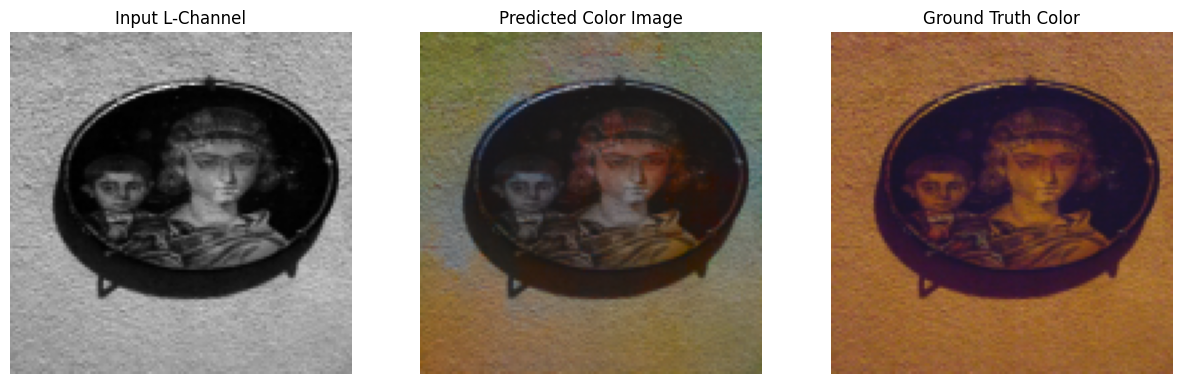

  - Batch 100/146
✅ Saved checkpoint for epoch 50 at /content/drive/MyDrive/ImageColorization/saved_models/ckpt-31
Time taken for epoch 50 is 58.86 sec
  Avg Gen Loss: 8.1154 | Avg Disc Loss: 0.9269 | Val PSNR: 19.48 | Val SSIM: 0.6694

✅ Training finished. Final checkpoint saved at /content/drive/MyDrive/ImageColorization/saved_models/ckpt-32


In [ ]:
print("\n--- Starting Fine-Tuning Session ---")
checkpoint.restore(ckpt_manager.latest_checkpoint)
fit(fine_tune_train_dataset, fine_tune_val_dataset, epochs=50)

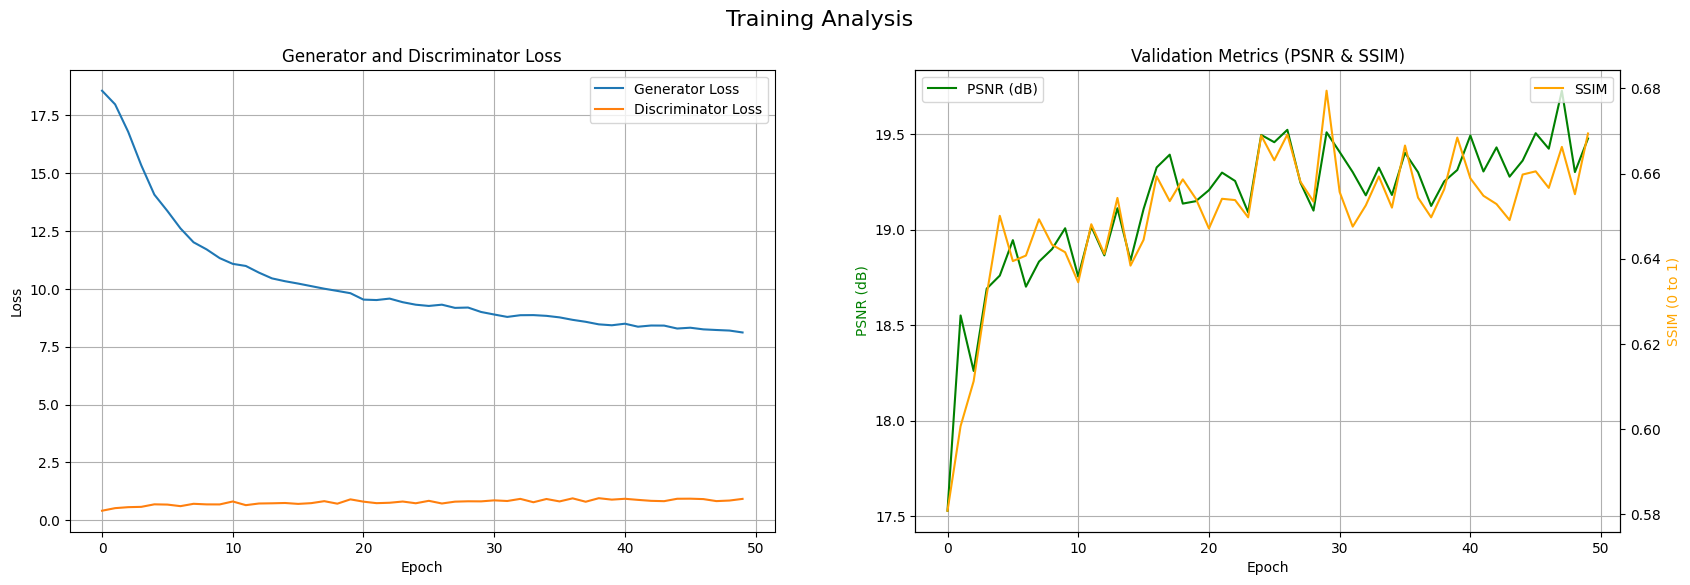

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot Losses on the first subplot
ax1.set_title("Generator and Discriminator Loss")
ax1.plot(gen_loss_history, label="Generator Loss")
ax1.plot(disc_loss_history, label="Discriminator Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Plot Metrics on the second subplot
ax2.set_title("Validation Metrics (PSNR & SSIM)")
ax2.plot(psnr_history, label="PSNR (dB)", color='g')
# We need a second y-axis for SSIM since its scale is different
ax2_ssim = ax2.twinx()
ax2_ssim.plot(ssim_history, label="SSIM", color='orange')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("PSNR (dB)", color='g')
ax2_ssim.set_ylabel("SSIM (0 to 1)", color='orange')
ax2.legend(loc='upper left')
ax2_ssim.legend(loc='upper right')
ax2.grid(True)

plt.suptitle("Training Analysis", fontsize=16)
plt.show()

Fréchet Inception Distance (FID) result: 72.471

The provided training plots and lower FID indicate a progressive learning trend over the additional 50 epochs. At this juncture, we have elected to conclude the current training phase. Our observations from previous iterations, across various λ (lambda) values and learning rates, consistently showed a stagnation in learning beyond a certain point, suggesting a potential limitation within the current training setup or dataset portion.

Moving forward, our objective is to significantly scale up the training process. This involves leveraging a substantially larger segment of the dataset, which we hypothesize will facilitate more robust learning and overcome the observed plateaus. This expanded training will be contingent upon access to computational resources that mitigate current GPU memory and processing time constraints, enabling a more comprehensive and extended training regimen essential for optimal model performance in image colorization.